In [38]:
from scipy.io import loadmat

matdata = loadmat("../data/raw_mat/BCICIV_calib_ds1d.mat", struct_as_record=True)

matdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [39]:
import numpy as np


sfreq = matdata['nfo']['fs'][0][0][0][0]
EEGData = matdata['cnt'].T
n_channels, n_samples = EEGData.shape

channels_names = [s[0] for s in matdata['nfo']['clab'][0][0][0]]

events_onset = matdata['mrk'][0][0][0]
events_codes = matdata['mrk'][0][0][1]

labels = np.zeros((1, n_samples), int)
labels[0, events_onset] = events_codes
cl_lab = [s[0] for s in matdata['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

nclasses = len(cl_lab)
nevents = len(events_onset)

# Print some information
print('Shape of EEG:', EEGData.shape)
print('Sample rate:', sfreq)
print('Number of channels:', n_channels)
print('Channel names:', channels_names)
print('Number of events:', len(events_onset))
print('Event codes:', np.unique(events_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [ ]:
import mne


We need the following information to create MNE structure:

- data ([ndarray]): [trials x chans x samples]
- y ([ndarray]): [class label array [1, labels]]
- sfreq ([int]): [sampling frequency]
- event_id ([dict]): [{1 :'pos', -1 : 'neg'} - class labels id]
- chan_names ([list]): [channel names in a list of strings]

In [40]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
    ch_names = channels_names,
    ch_types = ['eeg']*n_channels,
    sfreq    = sfreq )


print('Event created :', info)

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [60]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sfreq), int(2.5*sfreq))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(events_codes)):

    # Extract the onsets for the class
    cl_onsets = events_onset[events_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((n_channels, nsamples, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEGData[:, win+onset]

# the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

left_hand  = np.rollaxis(trials[cl1], 2, 0)
right_hand = np.rollaxis(trials[cl2], 2, 0)
data = np.concatenate([left_hand, right_hand])
Y = np.concatenate([-np.ones(left_hand.shape[0]),
                    np.ones(right_hand.shape[0])])
event_id = dict(left = -1, right = 1)
len_events = Y.shape[0]
ev = [i*sfreq*3 for i in range(len_events)]
events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(len_events,  dtype = int),
                          np.array(Y,  dtype = int)))

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [45]:
tmin = 0.5
epochs = mne.EpochsArray(data, info, events, tmin, event_id)
epochs.filter(l_freq=8, h_freq=32)
labels = epochs.events[:,-1]

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.2s
[Parallel(n_job

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

Creating RawArray with float64 data, n_channels=59, n_times=190473
    Range : 0 ... 190472 =      0.000 ...  1904.720 secs
Ready.


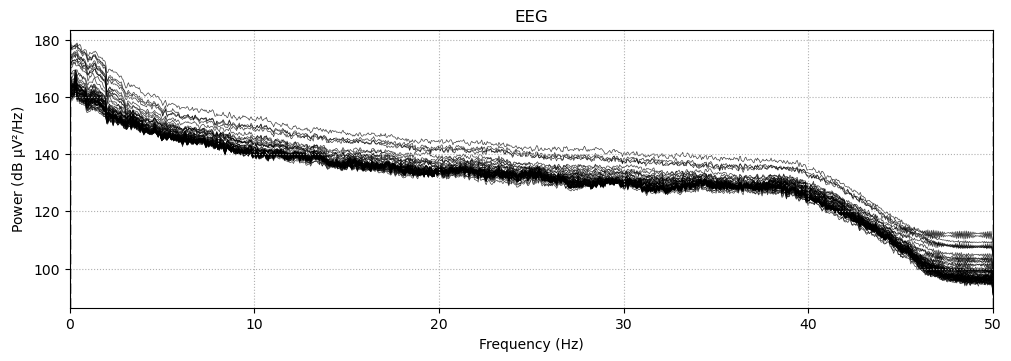

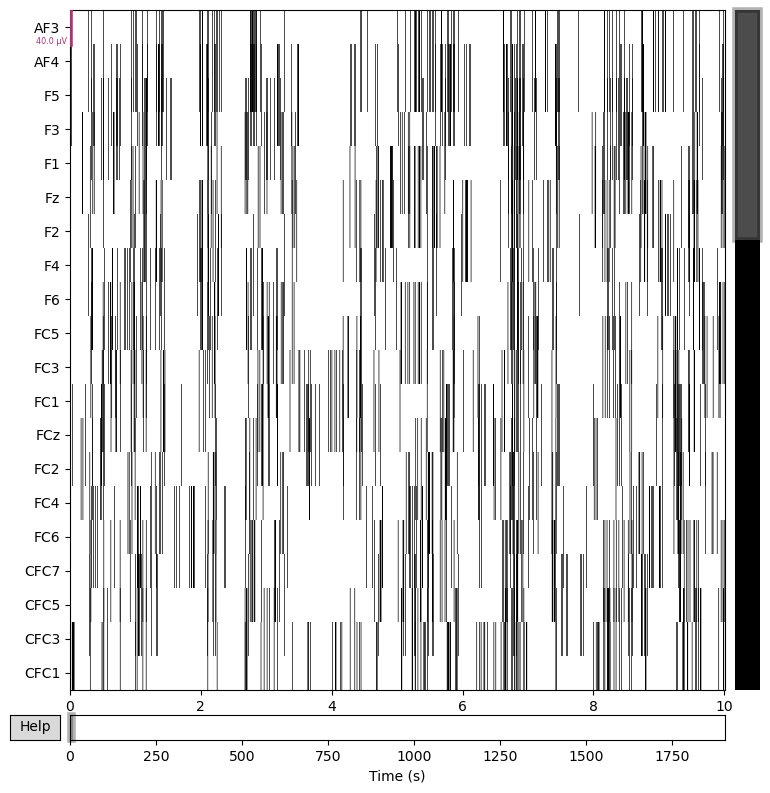

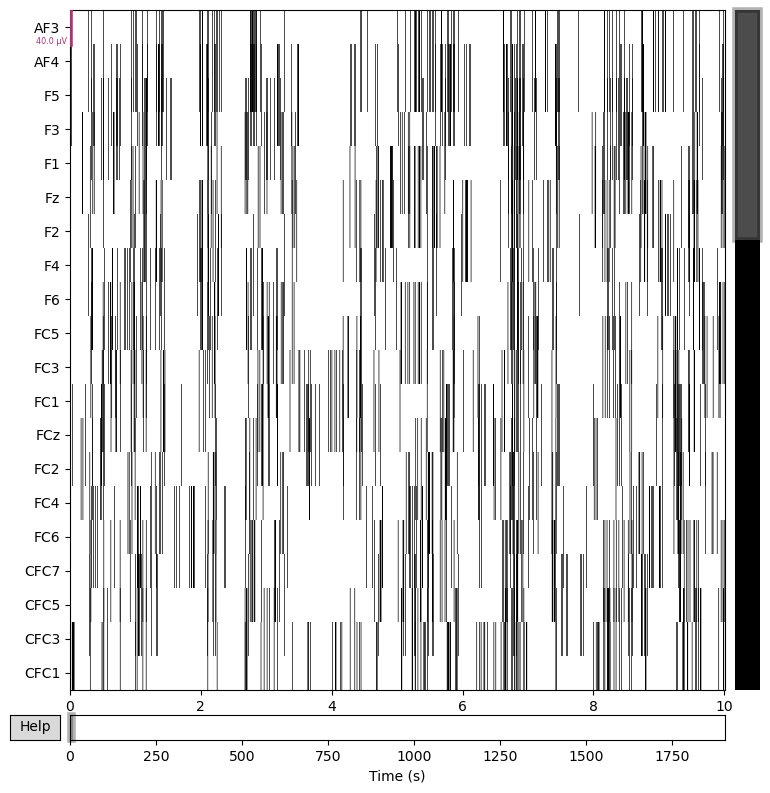

In [71]:
import mne
import numpy as np

raw = mne.io.RawArray(EEGData, info)
raw.plot()

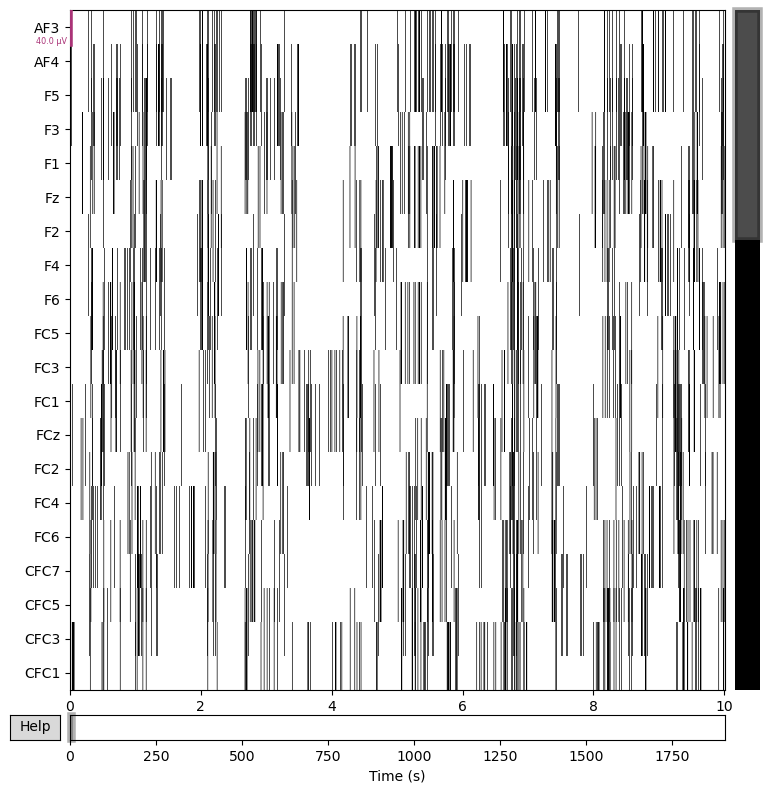

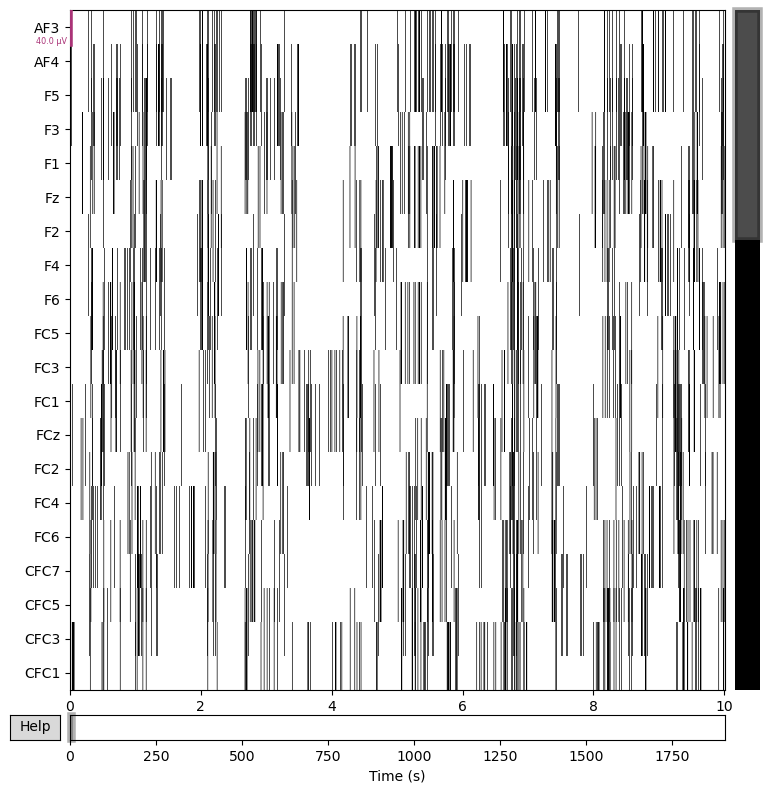

In [72]:
import pywt

def apply_wavelet_transform(raw, wavelet='db4', level=4):
    """
    This function use the pywt library to apply wavelet transform by using 'ondelette' signal.
    The wavelet transform is more precise than fourier transform because the output frequence are localised with time

    Parameters
    ----------
    raw: mne.io.Raw
        An MNE Raw object containing the EEG data with annotations.
    wavelet: Wavelet object or name string, optional
        'db4' 'ondelette' family naming 'Daubechies' wuth 4 coefficient's filter. This 'ondelette' is often used in EEG analysis.
    level: int, optional
        level of decomposition (more is high, more is precise)
    Returns
    -------
    raw: mne.io.Raw
        An MNE Raw object containing the EEG data with annotations filtered by wavelet transform
    """
    data = raw.get_data()
    cleaned_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        coeffs = pywt.wavedec(data[i, :], wavelet, level=level)

        threshold = 0.04
        coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
        reconstructed = pywt.waverec(coeffs, wavelet)
        
        # Ajustement de la taille si nécessaire
        if reconstructed.shape[0] != data.shape[1]:
            # Tronquer ou padding pour correspondre à la taille originale
            if reconstructed.shape[0] > data.shape[1]:
                cleaned_data[i, :] = reconstructed[:data.shape[1]]
            else:
                # Padding avec des zéros si nécessaire
                pad_width = data.shape[1] - reconstructed.shape[0]
                cleaned_data[i, :] = np.pad(reconstructed, (0, pad_width), 'constant')
        else:
            cleaned_data[i, :] = reconstructed

        # cleaned_data[i, :] = pywt.waverec(coeffs, wavelet)

    raw._data = cleaned_data
    return raw
raw_filter = apply_wavelet_transform(raw)
raw_filter.plot()

In [73]:
epochs

<EpochsArray | 200 events (all good), 0.5 – 2.49 s (baseline off), ~18.1 MB, data loaded,
 'left': 100
 'right': 100>

In [74]:
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# Recherche des meilleurs hyperparamètres
from sklearn.model_selection import GridSearchCV
param_grid = {
    'CSP__n_components': [2, 4, 6, 8],
    'LDA__solver': ['svd', 'lsqr']
}

clf = Pipeline([
    ('CSP', CSP()),
    ('LDA', LinearDiscriminantAnalysis())
])

X_train, X_test, y_train, y_test = train_test_split(
    epochs.get_data(),
    labels,
    test_size=0.2,
    random_state=42
)
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Meilleurs paramètres : {grid.best_params_}")
best_model = grid.best_estimator_
print(f"Score de validation croisée : {grid.best_score_}")

Computing rank from data with rank=None
    Using tolerance 5.5e+02 (2.2e-16 eps * 59 dim * 4.2e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e+02 (2.2e-16 eps * 59 dim * 4.3e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e+02 (2.2e-16 eps * 59 dim * 4.3e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using 

In [75]:
from sklearn.metrics import accuracy_score

predictions = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions):.3f}")

Accuracy: 0.900
